In [14]:
import gymnasium as gym
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class Config():
    def __init__(self):
        # env
        self.env_name = "CartPole-v1"
        self.gamma = 0.99
        self.num_action = 2
        self.state_dim = 4

        # replay
        self.buffer_size = 1000
        self.sequence_length = 10
        self.batchsize = 10

        # training
        self.total_episodes = 500000
        self.total_steps = 500000
        self.learning_rate = 2.3e-3
        self.weight_decay = 1e-4
        self.start_training_step = 1000
        self.train_frequency = 256
        self.epochs = 128
        self.test_frequency = 10000
        self.save_frequency = 50000
        self.save_path = 'best_model.pth'
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        ## target network
        self.use_soft_update = True
        self.update_frequency = 10
        self.tau = 0.005

        ## episode
        self.init_epsilon = 1.
        self.end_epsilon = 0.04
        self.exploration_fraction = 0.16
        self.decay_step = self.total_episodes * self.exploration_fraction

config = Config()

In [16]:
class Episode_Data():
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []

    def add(self, state, action, reward, next_state, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)

In [17]:
class Replay_Buffer():
    def __init__(self, buffer_size, sequence_length):
        self.buffer_size = buffer_size
        self.sequence_length = sequence_length
        self.real_size = 0
        self.index = 0

        self.data = []

    def add(self, data):
        if len(data.actions) < self.sequence_length:
            return
        self.data.append(data)
        if self.real_size == self.buffer_size:
            self.data.pop(0)

        self.real_size = min(self.real_size+1, self.buffer_size)
        self.index = (self.index+1) % self.buffer_size

    def sample(self, batchsize, sequence_length):
        episode_idxs = np.random.choice(self.real_size, batchsize, replace=False).astype(np.int64)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for episode_idx in episode_idxs:
            start_idx = np.random.randint(0, len(self.data[episode_idx].actions)-sequence_length+1, size = 1)[0]
            end_idx = start_idx + sequence_length

            states.append(np.array(self.data[episode_idx].states[start_idx:end_idx]))
            actions.append(np.array(self.data[episode_idx].actions[start_idx:end_idx]))
            rewards.append(np.array(self.data[episode_idx].rewards[start_idx:end_idx]))
            next_states.append(np.array(self.data[episode_idx].next_states[start_idx:end_idx]))
            dones.append(np.array(self.data[episode_idx].dones[start_idx:end_idx]))

        return torch.tensor(np.array(states)).transpose(1, 0), \
                torch.tensor(np.array(actions)).transpose(1, 0), \
                torch.tensor(np.array(rewards)).transpose(1, 0), \
                torch.tensor(np.array(next_states)).transpose(1, 0), \
                torch.tensor(np.array(dones)).transpose(1, 0)

In [18]:
class Model(nn.Module):
    def __init__(self, state_dim=4, num_action=2):
        super(Model, self).__init__()
        self.fc = nn.Linear(state_dim, 64)
        self.lstm = nn.LSTMCell(64, 64)
        self.Q = nn.Linear(64, num_action)

    def forward(self, state, h, c):
        x = F.relu(self.fc(state))
        h, c = self.lstm(x, (h, c))
        x = F.relu(h)
        Q = self.Q(x)
        return Q, h, c
    
    def init_hidden_state(self, batchsize):
        return torch.zeros((batchsize, 64)), torch.zeros((batchsize, 64))

In [19]:
def update_weights(model, target_model, use_soft_update, tau):
    if use_soft_update:
        with torch.no_grad():
            for target_param, online_param in zip(target_model.parameters(), model.parameters()):
                target_param.data.copy_(tau * online_param.data + (1.0 - tau) * target_param.data)
    else:
        with torch.no_grad():
            for target_param, online_param in zip(target_model.parameters(), model.parameters()):
                target_param.data.copy_(online_param.data)

In [20]:
def select_action(state, h, c, model, epsilon, num_action, config):
    state = torch.tensor(np.array(state)).unsqueeze(0).to(config.device)
    with torch.no_grad():
        Qs, h, c = model(state, h, c)
        Qs = Qs[0]
    if np.random.rand() > epsilon:
        action = Qs.argmax().item()
    else:
        action = np.random.choice(num_action, 1)[0]
    return action, h, c

In [21]:
def decay_epsilon(step, config):
    if step < config.decay_step:
        epsilon = config.init_epsilon - (step / config.decay_step) * (config.init_epsilon - config.end_epsilon)
    else:
        epsilon = config.end_epsilon
    return epsilon

In [22]:
def train(model, target_model, replay_buffer, batchsize, sequence_length, gamma, optimizer):
    optimizer.zero_grad()
    #torch.Size([10, 20, 4]) torch.Size([10, 20]) torch.Size([10, 20]) torch.Size([10, 20, 4]) torch.Size([10, 20])
    states, actions, rewards, next_states, dones = replay_buffer.sample(batchsize, sequence_length)
    h, c = model.init_hidden_state(batchsize)
    h_, c_ = target_model.init_hidden_state(batchsize)

    idxs = torch.arange(0, batchsize)
    loss = 0.
    for i, (state, action, reward, next_state, done) in enumerate(zip(states, actions, rewards, next_states, dones)):
        with torch.no_grad():
            next_Qs, h_, c_ = target_model(next_state, h_, c_)

        Qs, h, c = model(state, h, c)
        Qs = Qs[idxs, action].reshape(-1)

        next_actions = next_Qs.argmax(-1)
        next_Qs = next_Qs[idxs, next_actions].reshape(-1)
        targets = reward + gamma * (1 - done.float()) * next_Qs

        loss += ((targets - Qs)**2).mean()
    loss /= sequence_length
    loss.backward()
    optimizer.step()
    return loss.item()
    
def test(config, model, max_test_rewards):
    env = gym.make(config.env_name, render_mode="rgb_array")
    state, info = env.reset()
    total_rewards = 0.
    step = 0.
    start_time = datetime.now()
    done = False
    h, c = model.init_hidden_state(1)
    while not done:
        action, h, c = select_action(state, h, c, model, -1, config.num_action, config)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_rewards += reward
        state = next_state
        step += 1
    if total_rewards > max_test_rewards:
        max_test_rewards = total_rewards
        torch.save(model.state_dict(), config.save_path)
    print(f"Test Episode: Steps: {step} Rewards: {total_rewards}, Max_Test_Rewards: {max_test_rewards}, Duration: {datetime.now() - start_time}")
    return max_test_rewards, total_rewards, step

In [23]:
replay_buffer = Replay_Buffer(config.buffer_size, config.sequence_length)
model = Model(config.state_dim).to(config.device)
target_model = Model(config.state_dim).to(config.device)
update_weights(model, target_model, config.use_soft_update, config.tau)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
step = 0
env = gym.make(config.env_name, render_mode="rgb_array")
epsilon = config.init_epsilon
max_test_rewards = 0.
episode_rewards = []
episode_steps = []
max_episode_rewards = 0.
test_episode_rewards = []
test_episode_steps = []
losses = []

for episode in range(config.total_episodes):
    if config.total_steps is not None and step > config.total_steps:
        break
    start_time = datetime.now()
    state, info = env.reset()
    done = False
    total_rewards = 0.
    episode_step = 0.

    episode_data = Episode_Data()
    h, c = model.init_hidden_state(1)

    while not done:
        step += 1
        episode_step += 1
        action, h, c = select_action(state, h, c, model, epsilon, config.num_action, config)
        next_state, reward, terminated, truncated, info = env.step(action)
        total_rewards += reward
        done = terminated or truncated
        episode_data.add(state, action, reward, next_state, done)
        state = next_state
        if step % config.train_frequency == 0 and step >= config.start_training_step and replay_buffer.real_size > config.batchsize:
            for _ in range(config.epochs):
                loss = train(model, target_model, replay_buffer, config.batchsize, 
                             config.sequence_length, config.gamma, optimizer)
                losses.append(loss)
        if step % config.test_frequency == 0:
            max_test_rewards, test_rewards, test_steps = test(config, model, max_test_rewards)
            test_episode_rewards.append(test_rewards)
            test_episode_steps.append(test_steps)
        if step % config.save_frequency == 0:
            torch.save(model.state_dict(), f"{step}.pth")
        epsilon = decay_epsilon(step, config)

        if step % config.update_frequency or config.use_soft_update:
            update_weights(model, target_model, config.use_soft_update, config.tau)

    replay_buffer.add(episode_data)

    episode_rewards.append(total_rewards)
    episode_steps.append(episode_step)
    max_episode_rewards = max(max_episode_rewards, total_rewards)
    if episode % 100 == 0:
        print(f"Step {step}, Episode {episode}: Steps: {episode_step}, Rewards: {total_rewards}, Mean_Rewards: {np.array(episode_rewards[-min(100, len(episode_rewards)):]).mean():.4f}, Max_Rewards: {max_episode_rewards}, Loss: {np.array(losses[-min(1000, len(losses)):]).mean()}, Duration: {datetime.now() - start_time}, epsilon: {epsilon:.6f}")

C:\Users\CVH\AppData\Local\Temp\ipykernel_18096\4250451891.py:60: RuntimeWarning: Mean of empty slice.
  print(f"Step {step}, Episode {episode}: Steps: {episode_step}, Rewards: {total_rewards}, Mean_Rewards: {np.array(episode_rewards[-min(100, len(episode_rewards)):]).mean():.4f}, Max_Rewards: {max_episode_rewards}, Loss: {np.array(losses[-min(1000, len(losses)):]).mean()}, Duration: {datetime.now() - start_time}, epsilon: {epsilon:.6f}")
d:\anaconda3\envs\gym\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Step 27, Episode 0: Steps: 27.0, Rewards: 27.0, Mean_Rewards: 27.0000, Max_Rewards: 27.0, Loss: nan, Duration: 0:00:00.012401, epsilon: 0.999676
Step 2194, Episode 100: Steps: 9.0, Rewards: 9.0, Mean_Rewards: 21.6700, Max_Rewards: 82.0, Loss: 0.08527487146234128, Duration: 0:00:00.005000, epsilon: 0.973672
Step 4400, Episode 200: Steps: 10.0, Rewards: 10.0, Mean_Rewards: 22.0600, Max_Rewards: 82.0, Loss: 0.15612652779407973, Duration: 0:00:00.007636, epsilon: 0.947200
Step 6798, Episode 300: Steps: 19.0, Rewards: 19.0, Mean_Rewards: 23.9800, Max_Rewards: 95.0, Loss: 0.14762992052405077, Duration: 0:00:00.010624, epsilon: 0.918424
Step 9683, Episode 400: Steps: 36.0, Rewards: 36.0, Mean_Rewards: 28.8500, Max_Rewards: 163.0, Loss: 0.2244817939696617, Duration: 0:00:00.022445, epsilon: 0.883804
Test Episode: Steps: 243.0 Rewards: 243.0, Max_Test_Rewards: 243.0, Duration: 0:00:00.050220
Step 12379, Episode 500: Steps: 60.0, Rewards: 60.0, Mean_Rewards: 26.9600, Max_Rewards: 163.0, Loss: 0.

In [24]:
import pickle 
with open("log.pickle", "wb") as f:
    pickle.dump({"rewards": np.array(episode_rewards),
                 "steps": np.array(episode_steps),
                 "test rewards": np.array(test_episode_rewards),
                 "test steps": np.array(test_episode_steps),
                 "losses": np.array(losses)}, f)

50 50


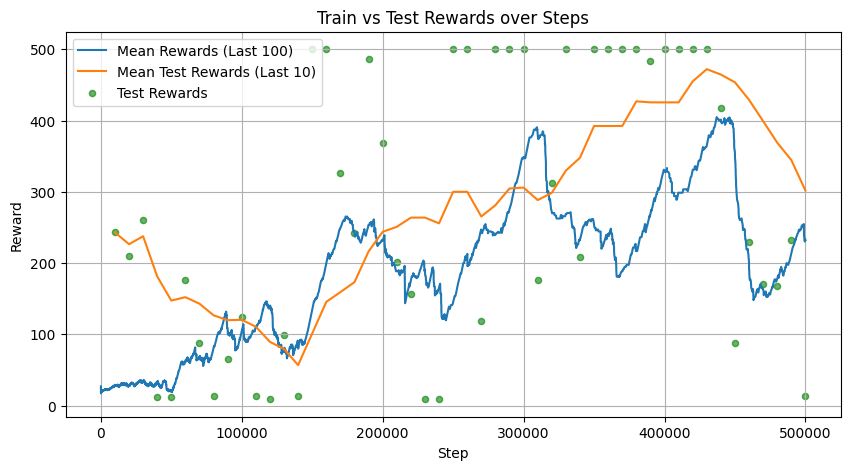

In [25]:
import matplotlib.pyplot as plt

test_steps = np.arange(config.test_frequency, config.total_steps+1, config.test_frequency)
train_step = 0
train_steps = []
for steps in episode_steps:
    train_step += steps
    train_steps.append(train_step)
print(len(test_steps), len(test_episode_rewards))

mean_rewards = []
mean_rewards_last10 = []
mean_test_rewards = []
for i in range(len(episode_rewards)):
    mean_rewards.append(np.array(episode_rewards)[max(0, i-100):i+1].mean())
    mean_rewards_last10.append(np.array(episode_rewards)[max(0, i-10):i+1].mean())
for i in range(len(test_episode_rewards)):
    mean_test_rewards.append(np.array(test_episode_rewards)[max(0, i-10):i+1].mean())

plt.figure(figsize=(10, 5))
plt.plot(train_steps, mean_rewards, label='Mean Rewards (Last 100)')
plt.plot(test_steps, mean_test_rewards, label='Mean Test Rewards (Last 10)')
plt.scatter(test_steps, test_episode_rewards, label='Test Rewards', alpha=0.6, s=20, color = 'green')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Train vs Test Rewards over Steps')
plt.legend()
plt.grid(True)
plt.show()

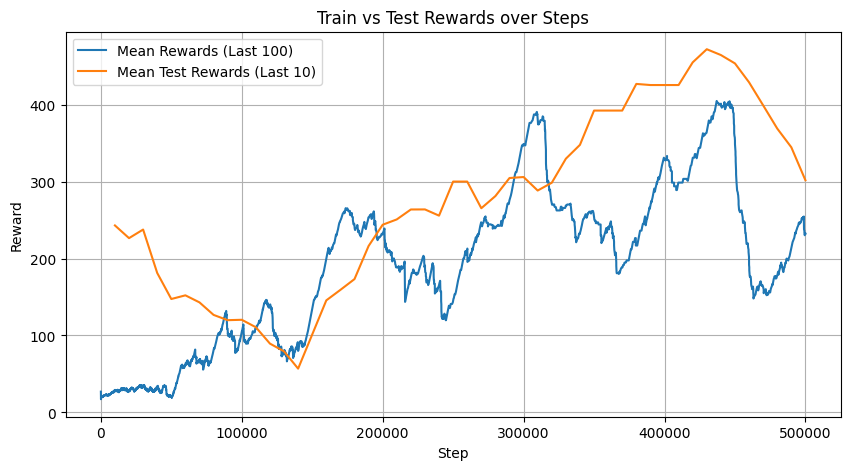

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(train_steps, mean_rewards, label='Mean Rewards (Last 100)')
plt.plot(test_steps, mean_test_rewards, label='Mean Test Rewards (Last 10)')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Train vs Test Rewards over Steps')
plt.legend()
plt.grid(True)
plt.show()